<a href="https://colab.research.google.com/github/atanilson/Comp702/blob/main/04_pytorch__custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notbook

## Domain Libaries

## 0. Import Pytorch and setup device agnostic code

In [ ]:
import torch
from torch import nn



In [ ]:
# Setup divice-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Downloading
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downlaoding data")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one
Downlaoding data
Unzipping


## 2. Becoming one with the data (Data Preparation and Data Exploration)

"If I had 8 hours to buiild a machine learning model, I'd spend the first 6 hours preparing my dataset."
Abraham Lassfunction

In [ ]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [ ]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing

PIL - Pillow p

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image Python's PIL
5. We'll then show the image and print metadata

In [ ]:
import random
from PIL import Image

random.seed(42)

# 1. Get image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class form path name
image_class = random_image_path.parent.stem #Parent is the Path, and stem is the end of the folder

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
#img

Random image path: data/pizza_steak_sushi/test/steak/690177.jpg
Image class: steak
Image height: 512
Image width: 382


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asanyarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channes]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorchFileReader
1. Turn your target data into tensor (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset`and
subsequently a torch.utils.data.DataLoader, we'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Tranform data with torchvision.tranforms

Trandorms help you get your umages ready to be used with model/perfom data augmentations

In [ ]:
# Write a tranform for images
data_tranform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Trun the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_tranform(img).dtype

torch.float32

In [ ]:
def plot_tranformed_image(image_paths, transform, n=3, seed=None):
    """
    Select random images and load/tranform
    then plot original vs tranformed
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Orininal\n Size: {f.size}")
            ax[0].axis(False)

            # Tranform and plot target image
            tranformed_image = transform(f).permute(1,2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(tranformed_image)
            ax[1].set_title(f"Tranformed\n Size: {tranformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_tranformed_image(image_paths=image_path_list,
                      transform=data_tranform,
                      n=3,
                      seed=None)

### 4. Option 1: Load image data using ÌmageFolder`

We can load image classfication data usin torchvision.datasets.ImageFolder - Prebuit loaded dataset

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_tranform, # a tranform for the data
                                  target_transform=None) # A tranfirm for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_tranform)

In [ ]:
# Ger class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

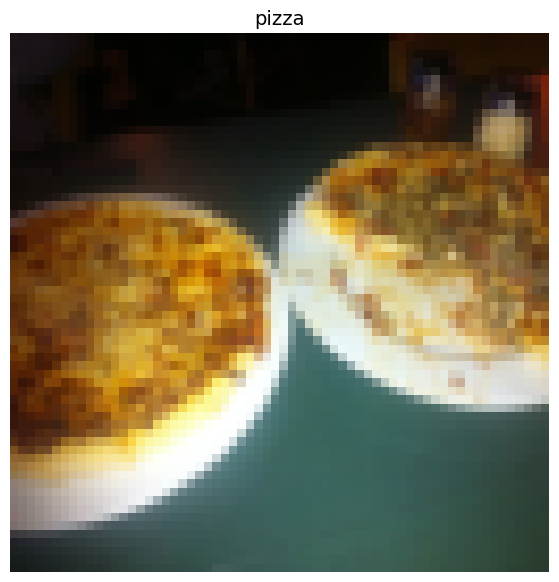

In [ ]:
# Rearrange the order dimmension
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Loaded Image into Dataloader

Tranfirm dataset into iterable and allows as to batchfy

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_datalaoder = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [ ]:
len(train_dataloader)

225

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channesls, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channesls, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file...
2. Wanto to be able get class names from the datetime_as_string
3. Want to able to get class as dictionaru form the Dataset

Pros:
* Create a `Dataset`out of almost anything

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Intace of torchvision.dataset.ImageFOlde()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir() to traverse a target director (in standard classification format)
3. Turn the class name into a dict and a list and return them.

In [ ]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class name form the target direcory
class_name_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_name_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(direcory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(direcory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn´t find any classes in {diectory}... please check file structure.")

    class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

All datasets that represent a map from keys to daa samples should be subclass

To create a custom dataste

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'll like to get data drom) as well as a tranform if we'd like
3. Create several atribute
4. Create a function to `laod_images()`, this funtion will open the image
5. Overite the `__len()__`
6. Overwrite the `__getitem()__`

In [ ]:
# 0.  Write a costom dataset class
from torch.utils.data import Dataset

# 1. Subclass
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None):
        super().__init__()
        # Get all of the image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create class and class to class_to_idx attribute
        self.classes, self.classes_to_idx = find_classes(target_dir)

    # 4. Create a function to loaded image
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number od sample"
        return len(self.paths)

    # 6. Overwrite __getitem__()  method to return a particular sample
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X,y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expect path in format: datafolde/class_name/image.jpg
        class_idx = self.classes_to_idx[class_name]

        # Tranform if necessary

        if self.transform:
            return self.transform(img), class_idx #return data, label (X,y)

        return img, class_idx

In [ ]:
# Create a tranform
from torchvision import transforms
train_tranforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])
test_tranforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [ ]:
# test out ImageFolderCustom

train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_tranforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                      transform=test_tranforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a72c43dd510>,
 <__main__.ImageFolderCustom at 0x7a71a6a1ff50>)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
len(train_data)

225

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.classes_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to vizualize.
2. to max
3. Set the random seed for reproducibility
4. Get a list os random sample indezes form the target dataset.
5. Setup a matplotlib plot.
6 Loop thought the random sample images/index and plot them with matplotlib
7. Make sure the dimension of our images line up with matplotlib(HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust displayu if n is too high
    if n>10:
        n = 10
        display_shape = False
        print(f"For dispaly, porposes, {n} shouldn´t be larger then 10")

    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop thoguh random idnex and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjues tensor dimentios for plotting
        target_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {target_image_adjust.shape}"
        plt.title(title)


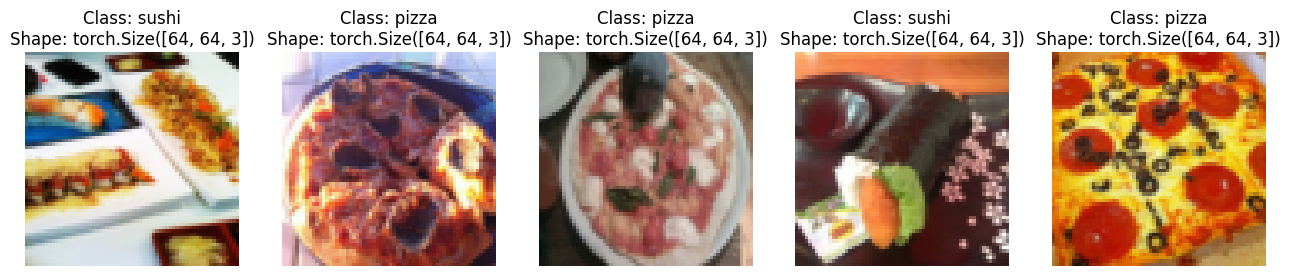

In [ ]:
# Display random images from the ImageFolder Create Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

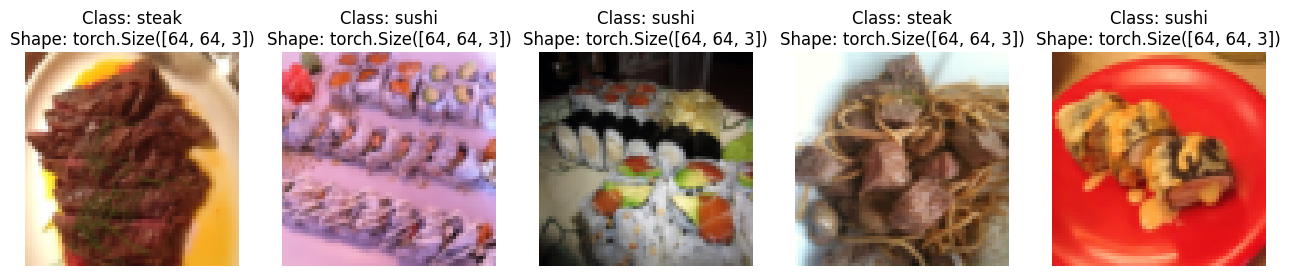

In [ ]:
# Display random images from the ImageFolderCostomDataset Create Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn Into DataLoader

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True
                                     )
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,# os.cpu_count(),
                                     shuffle=False
                                     )

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a71a6c98790>,
 <torch.utils.data.dataloader.DataLoader at 0x7a71a6c9b6d0>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of tranforms (Data Augmentation)

One type of data augmentation used to train PyTorch model to state of the art vision model

Result to a model that is more geniriliseble to unseen level

SOTA (State of the Art)

In [ ]:
# Lets look at TrivialAugument

from torchvision import transforms

train_tranform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()])
test_tranforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()])

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg')]

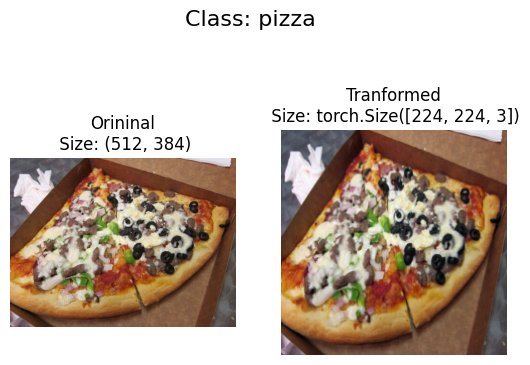

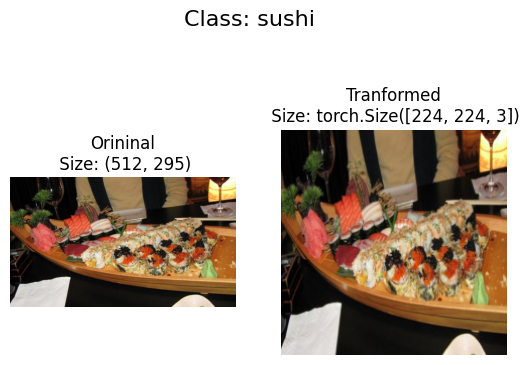

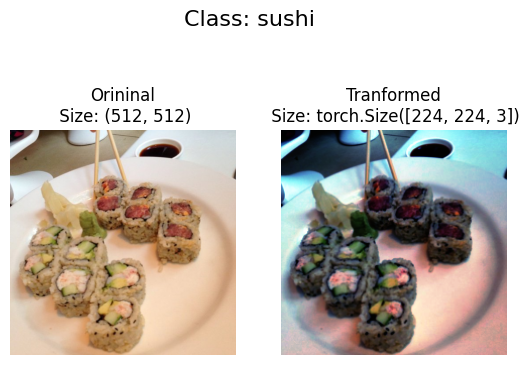

In [ ]:
# Plot random images
plot_tranformed_image(
    image_paths=image_path_list,
    transform=train_tranform,
    n=3,
    seed=None

)

## 7. Model 0: TinyVGG witout data augmentation

### 7.1 Creating tranform and laoding data for Model 0

In [ ]:
# Create simple tranform
simple_tranform = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [ ]:
# 1. Load and tranform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_tranform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_tranform)

# 2. Train then datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Datalaodes
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architetute copying TinyVGG from CNN Explainer
    """
    def __init__(self, input_shape:int, hidden_units: int, output_shape:int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*14*14,
                      out_features=output_shape)
        )

    def forward(self,x):
        x=self.conv_block_1(x)
        #print(x.shape)
        x=self.conv_block_2(x)
        #print(x.shape)
        x=self.classifier(x)
        #print(x.shape)
        #return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Benefit from operator fussion
        return x



In [ ]:
len(class_names)

3

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single iamge ot test the model

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[-0.0384,  0.0990, -0.0117],
        [-0.0374,  0.0997, -0.0129],
        [-0.0393,  0.1000, -0.0123],
        [-0.0354,  0.0990, -0.0155],
        [-0.0358,  0.0953, -0.0108],
        [-0.0401,  0.0982, -0.0140],
        [-0.0381,  0.0994, -0.0137],
        [-0.0430,  0.1043, -0.0144],
        [-0.0350,  0.1142, -0.0137],
        [-0.0368,  0.1036, -0.0138],
        [-0.0433,  0.0978, -0.0137],
        [-0.0393,  0.1018, -0.0132],
        [-0.0360,  0.0948, -0.0139],
        [-0.0361,  0.0940, -0.0120],
        [-0.0358,  0.0921, -0.0128],
        [-0.0362,  0.1019, -0.0136],
        [-0.0401,  0.1074, -0.0159],
        [-0.0389,  0.1009, -0.0144],
        [-0.0362,  0.0979, -0.0119],
        [-0.0397,  0.1034, -0.0144],
        [-0.0368,  0.0981, -0.0140],
        [-0.0391,  0.0969, -0.0110],
        [-0.0382,  0.1006, -0.0120],
        [-0.0370,  0.1022, -0.0118],
        [-0.0383,  0.1016, -0.0122],
        [-0.0404,  0.1024, -0.0126],
        [-0.0387,  0.0984, -0.0113],
 

## 7.4 use `torchinfo`to get an idea of the shape going throug a model

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 28, 28]           910
│    └─ReLU: 2-9                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-10                   [1, 10, 14, 14]           --
├─Sequentia

### 7.5 Create and test loss functions

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               datalaoder: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

    model.train()

    # Setup train loss and train accuracy value
    train_loss, train_acc = 0,0
    # Loop through data laoder data batches
    for batch, (X, y) in enumerate(datalaoder):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X) # Output model logits

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate accuracy metric
        y_pred_class  = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metric to get average loss and accuracy per batch
    train_loss = train_loss/len(datalaoder)
    train_acc = train_acc /len(datalaoder)
    return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logit = model(X)

            loss = loss_fn(test_pred_logit, y)
            test_loss += loss.item()

            # Calculate the accurecy
            test_pred_labels = test_pred_logit.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Train Function

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

    # Create empty result dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss":[],
               "test_acc":[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           datalaoder=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4} | Test loss:{test_loss:.4f}, Test acc: {test_acc:.4f}")

        # Updated results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results
    return results

### 7.7 Train evalute model_0()

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TineVGG
model_0 = TinyVGG(input_shape=3, # Number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# Start time
from timeit import default_timer as timer
start_time = timer()

#Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device
                        )

# End the time and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1068, Train Acc: 0.2734 | Test loss:1.1164, Test acc: 0.2604
Epoch: 1 | Train loss: 1.1107, Train Acc: 0.2734 | Test loss:1.1461, Test acc: 0.1979
Epoch: 2 | Train loss: 1.1184, Train Acc: 0.293 | Test loss:1.1365, Test acc: 0.2604
Epoch: 3 | Train loss: 1.1023, Train Acc: 0.3047 | Test loss:1.1049, Test acc: 0.2604
Epoch: 4 | Train loss: 1.0947, Train Acc: 0.4492 | Test loss:1.0831, Test acc: 0.5417
Total training time: 10.855 seconds


### 7.8 Plot a loss curve Model 0

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of a results dictionary."""
    # Get the loss values of the results dictionary
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

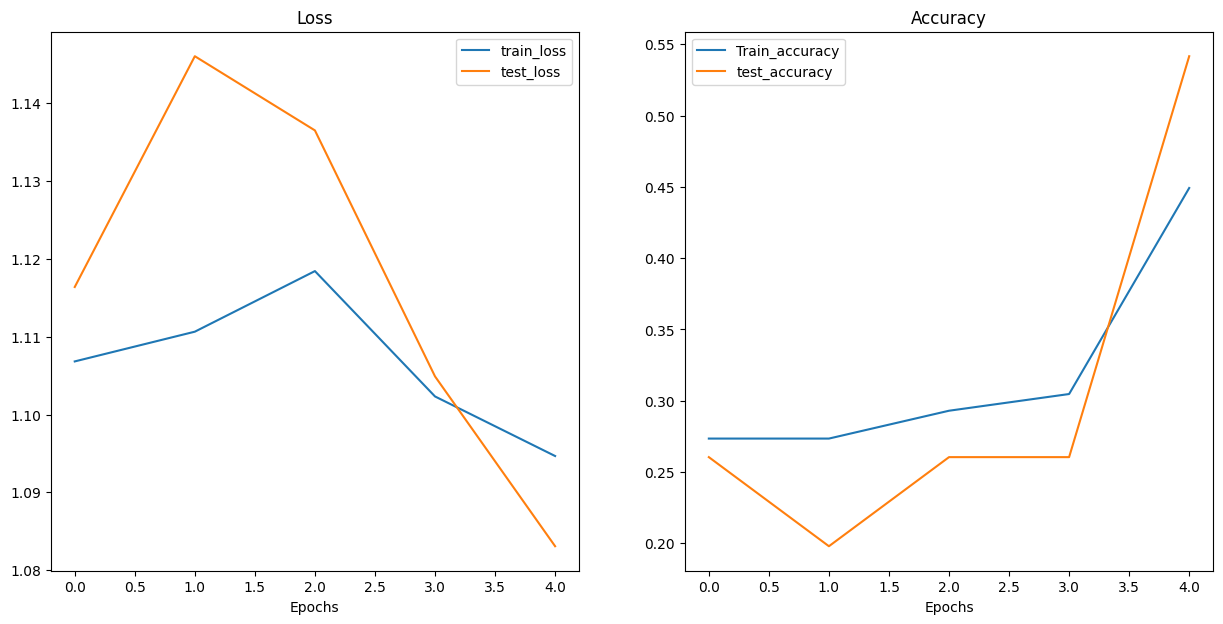

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should anideal loss curve look like?

To troubleshoot a model

## 9. Moddel 1: TinyVGG with Data Augmentation

### 9.1 Create tranform  with data augmentation

In [ ]:
# Creating training tranform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])
test_tranform_simple = transforms.Compose([transforms.Resize(size=(64,64)),
                                           transforms.ToTensor()])

### 9.2 Create train and test Dataset and Datalaoders with ag

In [ ]:
# Turn image folder into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_tranform_simple)

In [ ]:
# Data loaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_data_loader_augmented = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)
test_data_loader_simple = DataLoader(dataset=test_data_simple,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS)

### 9.3 Contrust and train the model

This time we'll be using the training data

In [ ]:
# Create model_1 and send to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss() #Creterion
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train
model_1_results = train(model=model_1,
                        train_dataloader=train_data_loader_augmented,
                        test_dataloader=test_data_loader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device
                        )

#End time
end_time = timer()
print(f"Total training time dor model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1429, Train Acc: 0.3516 | Test loss:1.1836, Test acc: 0.2604
Epoch: 1 | Train loss: 1.1076, Train Acc: 0.4258 | Test loss:1.1062, Test acc: 0.2604
Epoch: 2 | Train loss: 1.0912, Train Acc: 0.4258 | Test loss:1.1094, Test acc: 0.2604
Epoch: 3 | Train loss: 1.1029, Train Acc: 0.3047 | Test loss:1.1143, Test acc: 0.2604
Epoch: 4 | Train loss: 1.0884, Train Acc: 0.4258 | Test loss:1.1211, Test acc: 0.2604
Total training time dor model_1: 11.206 seconds


### 9.4 Plot lost curve model 1

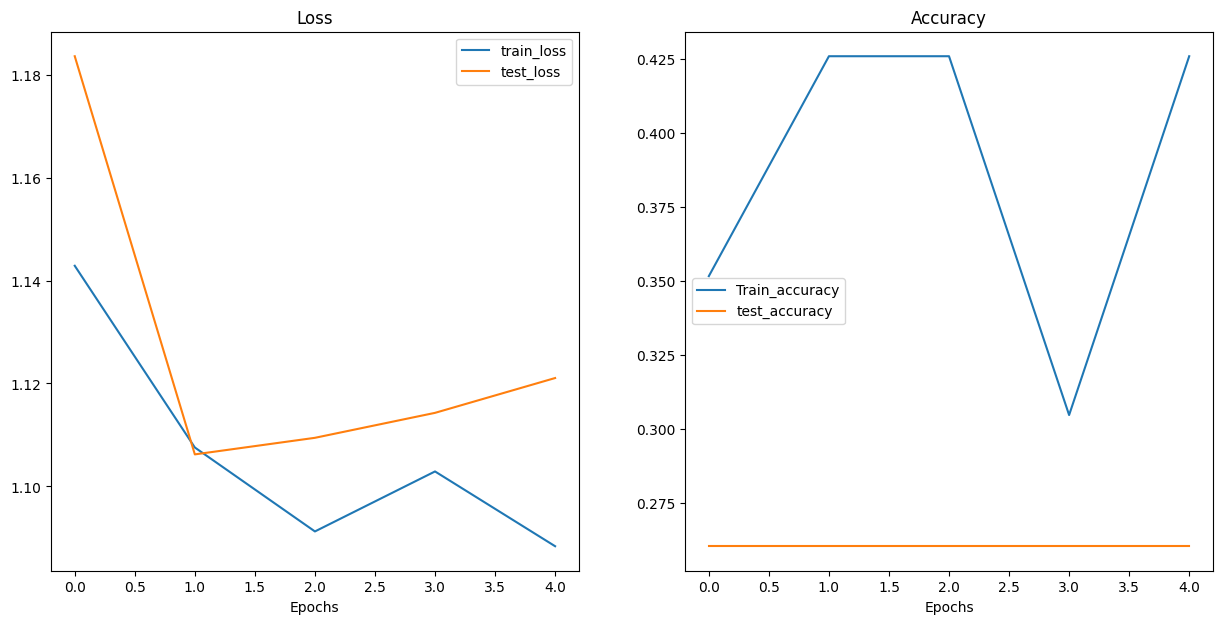

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

1. Hard code
2. PyTorch Tensorboard
3. Weight and Bias

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)


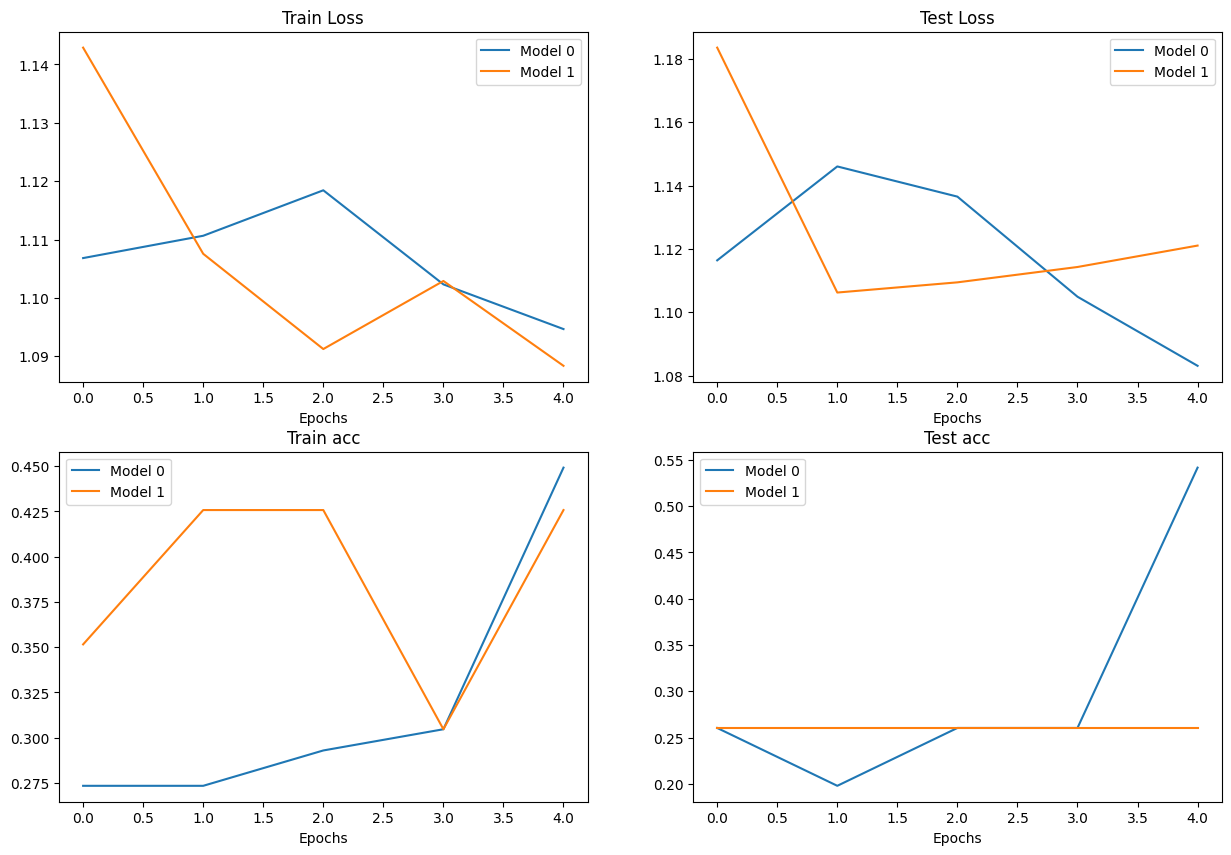

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

#Test Loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()


#Accurecy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()

#Test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

## Making a prediciton on custom image

In [ ]:
# Download custom image
import requests

custom_image_path = data_path/"04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with  open(custom_image_path,"wb") as f:
        #request = requests.get(***"https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg")
        print(f"Downlaoding {custom_image_path}...")
        f.write(request.content)
else:
    print(f"Alread exist skippind download")

Downlaoding data/04-pizza-dad.jpeg...


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format our model was trained on

In [ ]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

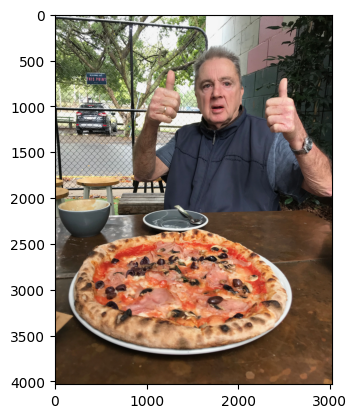

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [ ]:
print(f"Costom image tensor: \n {custom_image_uint8}")
print(f"Costom image shape: \n {custom_image_uint8.shape}")
print(f"Costom image type: \n {custom_image_uint8.dtype}")
#print(f"Costom image tensor: \n {custom_image_uint8}")

Costom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Costom image shape: 
 torch.Size([3, 4032, 3024])
Costom image t

### 11.2 Making a prediction on a custom image with a trained PyTOrch model

In [ ]:
# Try to make a predition in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load in the costom image and converrt to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

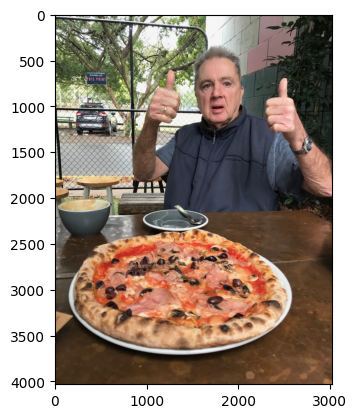

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x758524 and 1960x3)

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])

# Tranform target image
custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

torch.Size([3, 64, 64])

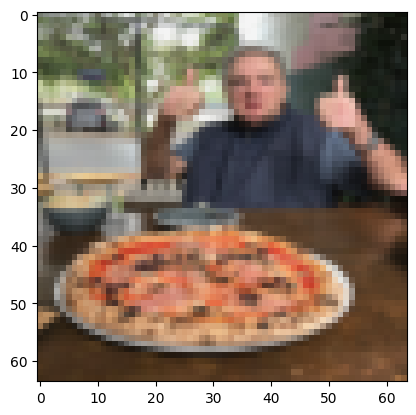

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
# This will error no bath size
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x196 and 1960x3)

In [ ]:
# THis should work added a batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [ ]:
custom_image_pred

tensor([[ 0.0828, -0.0254, -0.0838]])

To make a predition on a custom image: we had to:

Load the image turn into tensor
same datatype
same shape
bath size of 1
make sure the image is on the same divice as ou model


In [ ]:
# Convert logits -> Predition probabilities
custom_image_pred_prob = torch.softmax(custom_image_pred, dim=1)

# Probabulit label
custom_image_pred_label = torch.argmax(custom_image_pred_prob, dim=1)

In [ ]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction label

In [ ]:
import matplotlib.pyplot as plti

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device=device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image/255

    if transform:
        target_image = transform(target_image)

    model.eval()
    with torch.inference_mode():
        # Add the batch dimention
        target_image = target_image.unsqueeze(0)

        target_image_pred = model(target_image.to(device))

    # Convert logits
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plti.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimention and rearenge

    if class_names:
        title=f"Pred: {class_names[target_image_pred_label.cpu()]} | Prop: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    print(title)
    #plti.title(title)
    #plti.axis(False)


Pred: pizza | Prop: 0.364


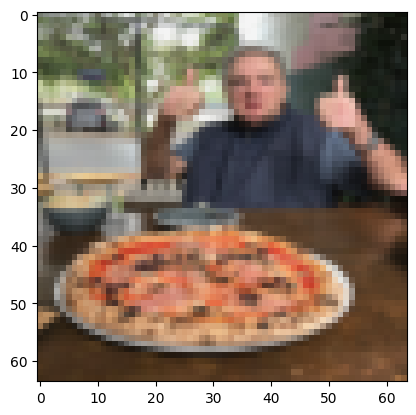

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)